In [34]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
import logging


In [36]:
# Set up logging
logging.basicConfig(level=logging.INFO)

# Load the dataset (replace 'Sample_Longlist_Data.xlsx' with the actual filename)
try:
    df = pd.read_excel('Sample_Longlist_Data.xlsx')
    logging.info("Dataset loaded successfully.")
except FileNotFoundError:
    logging.error("File not found. Please check the file name and path.")
    raise

# Verify that necessary columns exist in the dataset
required_columns = [
    'sellerproductcount', 'sellerratings', 'sellerdetails', 
    'businessaddress', 'Hero Product 1 #ratings', 'Hero Product 2 #ratings'
]
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    logging.error(f"Missing columns in dataset: {missing_cols}")
    raise Exception(f"Missing columns in dataset: {missing_cols}")

# Display first few rows
df.head()


INFO:root:Dataset loaded successfully.


,Date Added,category,sellerlink,sellerlink-url,sellerstorefront-url,sellerproductcount,sellerratings,sellerdetails,seller business name,businessaddress,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Hero Product 1 #ratings,Hero Product 2 #ratings,Sample brand name,Sample Brand URL
0,2020-11-15,Garden,Seller 1,Seller 1-link,Seller 1-storefrontlink,"1-16 of over 100,000 results",88% positive in the last 12 months (118 ratings),Lohas Living Inc James Mazzello US 845 3RD Ave...,Business Name:Lohas Living Inc,411 THEODORE FREMD AVESTE 206 SOUTHRyeNY10580-...,16,17,11,12,5873,4957,Visit the YAMAZAKI Store,https://www.amazon.de/-/en/stores/YAMAZAKI/pag...
1,2020-11-15,Garden,Seller 2,Seller 2-link,Seller 2-storefrontlink,NaN,90% positive in the last 12 months (566 ratings),Herzlich Willkommen im Amazon Shop von 1a-Hand...,Business Name:1a-Handelsagentur,1a HandelsagenturLindenallee 2MalchowMecklenbu...,0,2,2,9,0,0,Visit the tesa Store,https://www.amazon.de/-/en/stores/tesa/page/12...
2,2020-11-15,Garden,Seller 3,Seller 3-link,Seller 3-storefrontlink,"1-16 of over 2,000 results",85% positive in the last 12 months (75 ratings),67878u6i7 is committed to providing each custo...,Business Name:nantongaohuanfangzhipinyouxiango...,zhongnanshijicheng27zhuang1410haochongchuanqun...,15,0,25,12,164,162,TXYFYP,https://www.amazon.de/-/en/s/ref=bl_dp_s_web_0...
3,2020-11-15,Garden,Seller 4,Seller 4-link,Seller 4-storefrontlink,1-16 of 123 results,NaN,7 days home life supermarket is committed to p...,Business Name:Zhengzhou Yaoqiong Trading Company,河南省中兴南路福禄街自贸试验区郑州片区（郑东）河南商会大厦1901室450000CN,1,0,0,0,0,0,SHIFENG,https://www.amazon.de/-/en/s/ref=bl_dp_s_web_0...
4,2020-11-15,Garden,Seller 5,Seller 5-link,Seller 5-storefrontlink,"1-16 of over 1,000 results",81% positive in the last 12 months (52 ratings),78 68yui678 is committed to providing each cus...,Business Name:shenzhenfeichangshangmeimaoyiyou...,minzhidadaoshaxialaocun94dongA901longhuaxinqus...,16,0,31,15,224,113,YUOKI99,https://www.amazon.de/-/en/s/ref=bl_dp_s_web_0...


In [38]:
# 1. Parse product_count from 'sellerproductcount'
df['product_count'] = (
    df['sellerproductcount']
    .str.extract(r'over ([\d,]+)', flags=re.IGNORECASE)  # Extract the numeric part after "over"
    .replace(',', '', regex=True)                       # Remove commas
    .astype(float)                                      # Convert to float
    .fillna(0)                                          # Fill missing values with 0
)


In [40]:
# 2. Extract positive_percentage and rating_count from 'sellerratings'
df['positive_percentage'] = (
    df['sellerratings']
    .str.extract(r'(\d+)%')   # Extract percentage
    .astype(float)
    .fillna(0)
)
df['rating_count'] = (
    df['sellerratings']
    .str.extract(r'(\d+) ratings')  # Extract the number before "ratings"
    .astype(float)
    .fillna(0)
)

In [42]:
# 3. Extract phone and email from 'sellerdetails'
phone_pattern = r'(\+?\d{1,3}[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4})'
email_pattern = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'

# Convert sellerdetails to string to handle NaN safely
df['sellerdetails'] = df['sellerdetails'].astype(str)

df['phone'] = (
    df['sellerdetails']
    .str.findall(phone_pattern)
    .apply(lambda x: x[0] if len(x) > 0 else np.nan)
)
df['email'] = (
    df['sellerdetails']
    .str.findall(email_pattern)
    .apply(lambda x: x[0] if len(x) > 0 else np.nan)
)

In [44]:
# 4. Extract country from 'businessaddress' and filter out Chinese sellers (CN)
df['country'] = (
    df['businessaddress']
    .str.extract(r'\b(US|DE|CN)\b', flags=re.IGNORECASE)[0]  # Extract country code
    .str.upper()  # Convert to uppercase (US, DE, CN)
)


In [46]:
# Remove rows with missing country codes 
df = df.dropna(subset=['country'])
logging.info("Dropped rows with missing country codes.")

INFO:root:Dropped rows with missing country codes.


In [48]:
# Exclude Chinese sellers
df = df[df['country'] != 'CN']
logging.info("Excluded Chinese sellers.")

INFO:root:Excluded Chinese sellers.


In [50]:
# 5. Sanitize Hero Product ratings
for col in ['Hero Product 1 #ratings', 'Hero Product 2 #ratings']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
df['hero_ratings'] = df['Hero Product 1 #ratings'] + df['Hero Product 2 #ratings']


In [52]:
# 6. Calculate a binary indicator for contact availability
df['has_contact'] = np.where(
    df['phone'].notna() | df['email'].notna(), 1, 0
)


In [54]:
# 7. Normalize key metrics using MinMaxScaler
metrics = ['product_count', 'positive_percentage', 'rating_count', 'hero_ratings', 'has_contact']
scaler = MinMaxScaler()
df[metrics] = scaler.fit_transform(df[metrics])

In [56]:
# 8. Assign weights and calculate total score for each seller
weights = {
    'product_count': 0.3,
    'positive_percentage': 0.25,
    'rating_count': 0.2,
    'hero_ratings': 0.2,
    'has_contact': 0.05
}
df['score'] = (
    df['product_count'] * weights['product_count'] +
    df['positive_percentage'] * weights['positive_percentage'] +
    df['rating_count'] * weights['rating_count'] +
    df['hero_ratings'] * weights['hero_ratings'] +
    df['has_contact'] * weights['has_contact']
)

In [58]:
# 9. Rank sellers by score and select the top 20
top_sellers = df.sort_values('score', ascending=False).head(20)

In [60]:
# 10. Output relevant columns
result = top_sellers[[ 
    'product_count', 'positive_percentage', 'rating_count', 
    'hero_ratings', 'has_contact', 'country', 'phone', 'email', 'score'
]]

# Display the top 10 results for a quick preview
print(result.head(10))

      product_count  positive_percentage  rating_count  hero_ratings  \
780        1.000000                 0.90      0.000000      0.378698   
886        0.500000                 0.82      0.000000      1.000000   
889        0.000000                 0.86      1.000000      0.000000   
418        0.000000                 0.82      0.758621      0.000395   
601        0.166667                 0.90      0.000000      0.110389   
1767       0.000000                 1.00      0.000000      0.144400   
499        0.166667                 0.60      0.000000      0.060237   
825        0.000000                 0.00      0.000000      0.003436   

      has_contact country          phone                      email     score  
780           0.0      DE            NaN                        NaN  0.600740  
886           0.0      DE            NaN                        NaN  0.555000  
889           0.0      DE            NaN                        NaN  0.415000  
418           1.0      DE  0322

# Distribution of Scores Across All Sellers

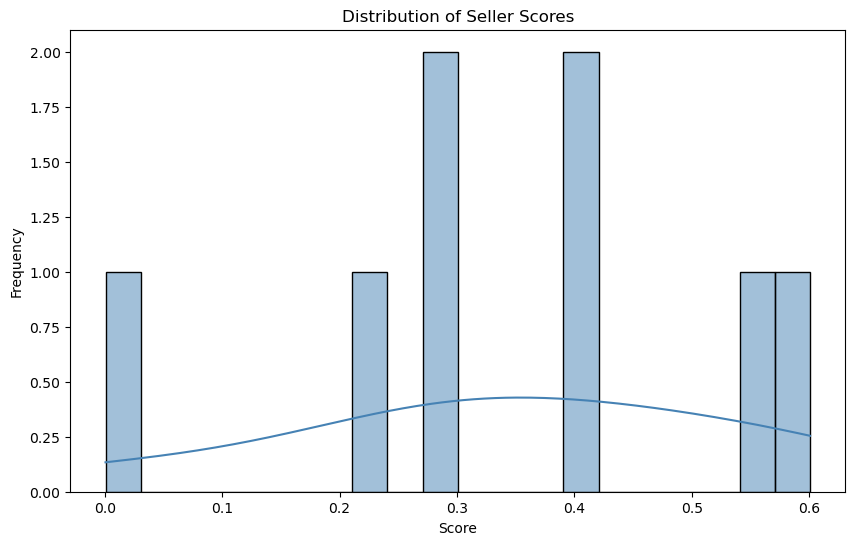

In [69]:
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], bins=20, kde=True, color='steelblue')
plt.title('Distribution of Seller Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


# Boxplots for Normalized Metrics for Top Sellers

C:\Users\Admin\AppData\Local\Temp\ipykernel_9836\2978411463.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Metric', y='Value', data=melted, palette='Set3')


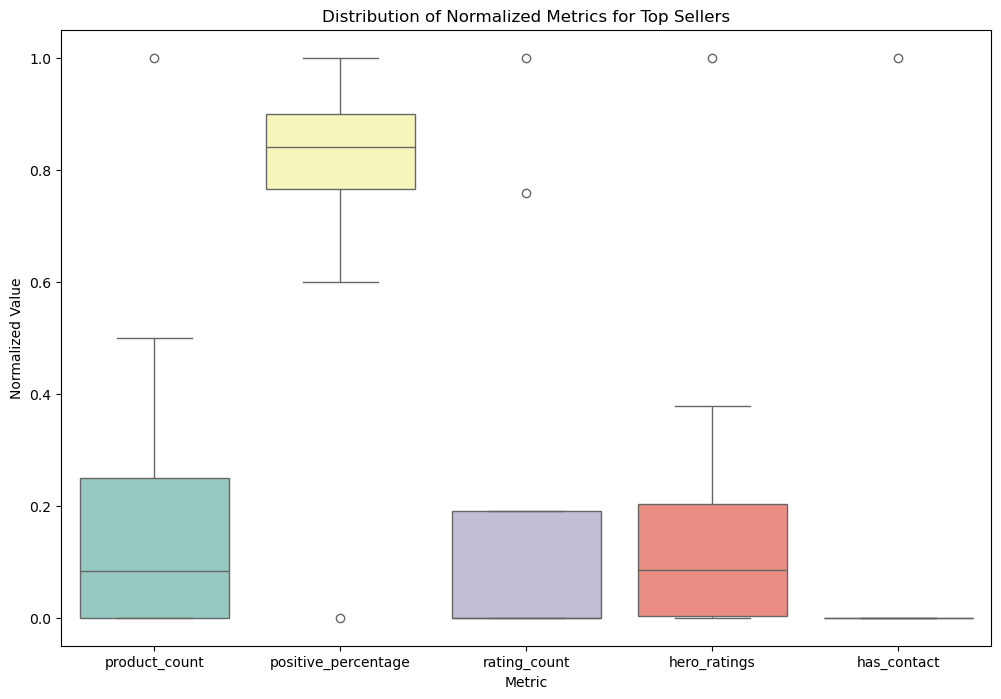

In [72]:
# Melt the dataframe for easier plotting with seaborn
melted = result.melt(id_vars=['score', 'country'], 
                     value_vars=['product_count', 'positive_percentage', 'rating_count', 'hero_ratings', 'has_contact'], 
                     var_name='Metric', 
                     value_name='Value')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Metric', y='Value', data=melted, palette='Set3')
plt.title('Distribution of Normalized Metrics for Top Sellers')
plt.xlabel('Metric')
plt.ylabel('Normalized Value')
plt.show()
